In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score,ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import warnings 
warnings.filterwarnings("ignore") # Prevents visual warnings and ignores them

In [136]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [137]:
df = pd.read_csv("wines_SPA.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [138]:
# check for and delete any duplicates
print(f"There are {df.duplicated().sum()} duplicated rows in this dataset.")
print("Deleting duplicates...")
df.drop_duplicates(inplace = True)
print(f"Now there are {df.duplicated().sum()} duplicated rows in this dataset.")

There are 5452 duplicated rows in this dataset.
Deleting duplicates...
Now there are 0 duplicated rows in this dataset.


In [139]:
# check for missing values
df.isna().sum()

winery           0
wine             0
year             2
rating           0
num_reviews      0
country          0
region           0
price            0
type           106
body           271
acidity        271
dtype: int64

In [140]:
# Since we are trying to find the overall quality of wine removing the missing
# missing values of these won't affect much.
df.dropna(subset= ['year'], inplace=True)
df.dropna(subset= ['type'], inplace=True)
df.isna().sum()

winery           0
wine             0
year             0
rating           0
num_reviews      0
country          0
region           0
price            0
type             0
body           165
acidity        165
dtype: int64

Missing values in body and acidity. I Will most likely use the mean or mode for this when I do machine learning.

In [141]:
# drop country since they are all from Spain
df = df.drop(columns = 'country')

In [142]:
df = df.drop(columns = 'winery')

In [143]:
df.dtypes

wine            object
year            object
rating         float64
num_reviews      int64
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object

In [144]:
# check for categorical inconsistencies 
for col in list(df.select_dtypes(include='object')):
  print(col)
  print(df[col].value_counts())
  print()

wine
Tinto                               56
Unico                               41
Valbuena 5o                         32
Reserva                             31
Priorat                             26
                                    ..
La Navilla                           1
Vobiscum                             1
Carinena Parcela 15 Vinas Viejas     1
Onomastica Rioja Reserva             1
Oloroso 30 Years Old V.O.R.S         1
Name: wine, Length: 768, dtype: int64

year
2016    236
2017    223
2015    200
2018    176
2014    157
       ... 
1953      1
1972      1
1974      1
1931      1
1925      1
Name: year, Length: 71, dtype: int64

region
Ribera del Duero     538
Rioja                479
Priorato             240
Toro                  81
Castilla y Leon       48
                    ... 
Monterrei              1
Malaga                 1
Jerez Cream            1
Condado de Huelva      1
Tarragona              1
Name: region, Length: 69, dtype: int64

type
Ribera Del Duero Red    5

Everything seems to be fine.

Text(0, 0.5, 'body')

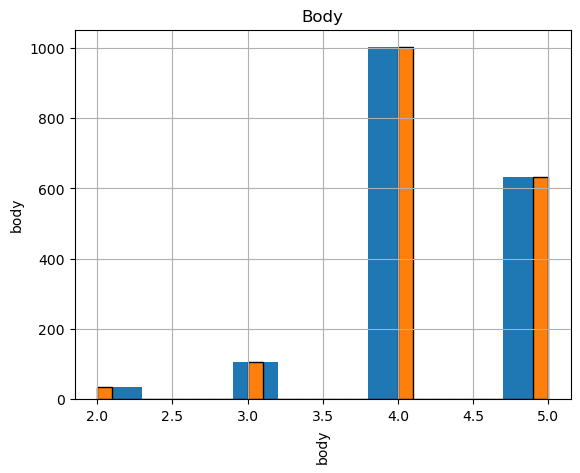

In [145]:
df['body'].hist()
ax=df['body'].hist(bins = 30, edgecolor = 'black')
ax.set_title('Body')
ax. set_xlabel("body", rotation = 90)
ax.set_ylabel('body')

Text(0, 0.5, 'rating')

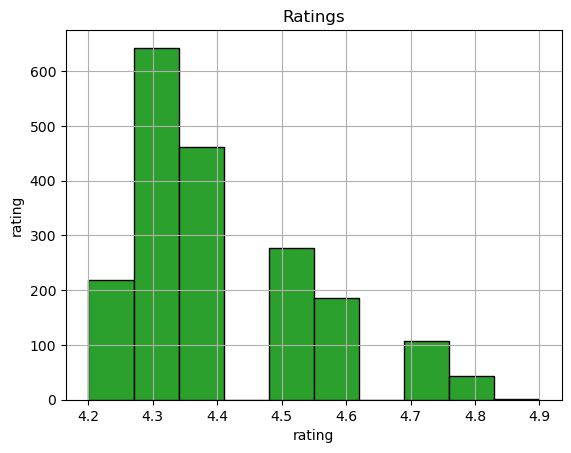

In [146]:
df['rating'].hist()
ax=df['rating'].hist()
ax=df['rating'].hist(bins = 10, edgecolor = 'black')
ax.set_title('Ratings')
ax. set_xlabel("rating")
ax.set_ylabel('rating')

Text(0, 0.5, 'acidity')

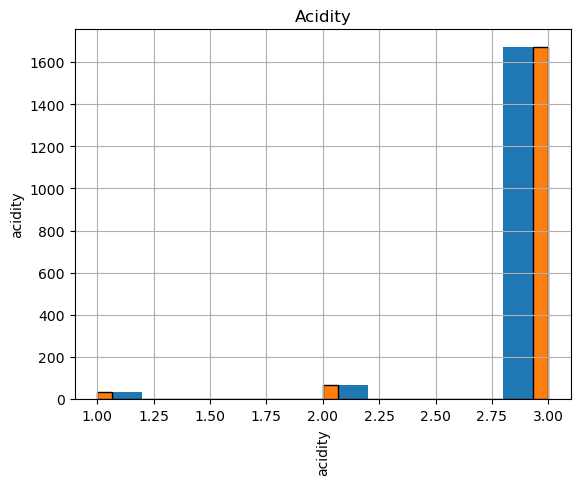

In [147]:
df['acidity'].hist()
ax=df['acidity'].hist(bins = 30, edgecolor = 'black')
ax.set_title('Acidity')
ax. set_xlabel("acidity", rotation = 90)
ax.set_ylabel('acidity')

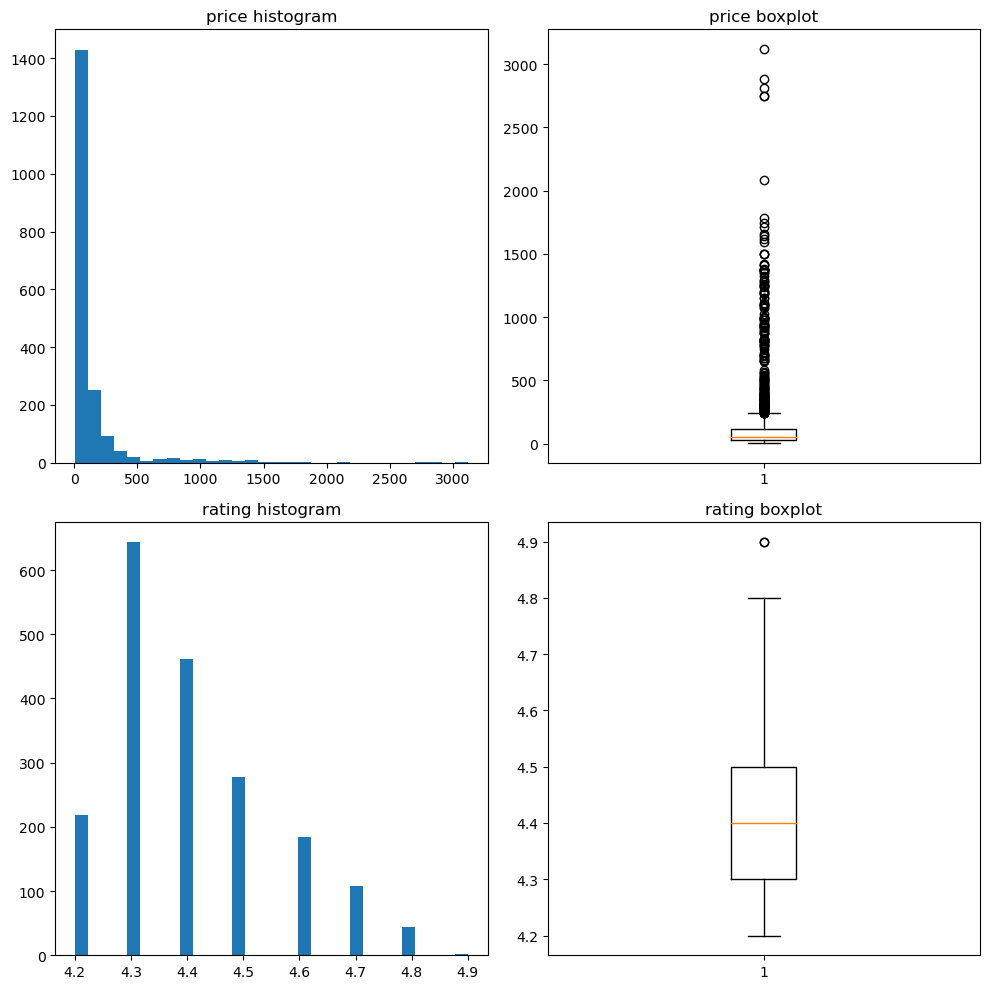

In [148]:
target = ['price', 'rating']

target_df = df[['price', 'rating']]

fig, axes = plt.subplots(nrows = len(target), ncols = 2, figsize = (10, 10))

for i, col in enumerate(target_df):

    axes[i][0].hist(df[col], bins = 30)
    axes[i][0].set_title(f"{col} histogram")
    
    axes[i][1].boxplot(df[col])
    axes[i][1].set_title(f"{col} boxplot")

plt.tight_layout()

Wine $500 and under has more reviews since it is more command to drink. The average wine rating varies from 4.2-4.5.

In [149]:
df[df['rating'] == 4.3]

,wine,year,rating,num_reviews,region,price,type,body,acidity
1114,Vina Ardanza Reserva,2009,4.3,10273,Rioja,24.38,Rioja Red,4.0,3.0
1115,Vina Ardanza Reserva,2012,4.3,9092,Rioja,20.00,Rioja Red,4.0,3.0
1117,Seleccion Especial,2016,4.3,7293,Sardon de Duero,17.48,Red,4.0,3.0
1118,Vina Tondonia Reserva,2008,4.3,6521,Rioja,37.90,Rioja Red,4.0,3.0
1119,Toro,2010,4.3,6345,Toro,79.75,Toro Red,5.0,3.0
...,...,...,...,...,...,...,...,...,...
1816,Alomado,2018,4.3,25,Rioja,46.95,Rioja Red,4.0,3.0
1817,Octogenarius,2015,4.3,25,Rioja,36.90,Grenache,5.0,3.0
1818,Gran Reserva,2000,4.3,25,Rioja,48.81,Rioja Red,4.0,3.0
1819,Pinot Noir,2020,4.3,25,Sierras de Malaga,33.50,Red,4.0,3.0


# Multivariate Visuals

In [150]:
corr = df.corr(numeric_only = True)

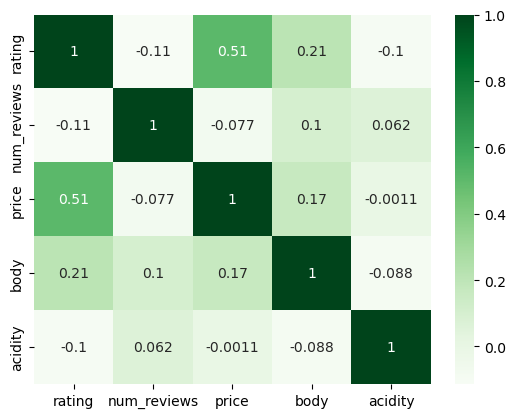

In [151]:
sns.heatmap(corr, cmap = 'Greens', annot = True);

Does wine from a particular region get a higher rating than others?

Do expensive wines get better ratings compared to others?

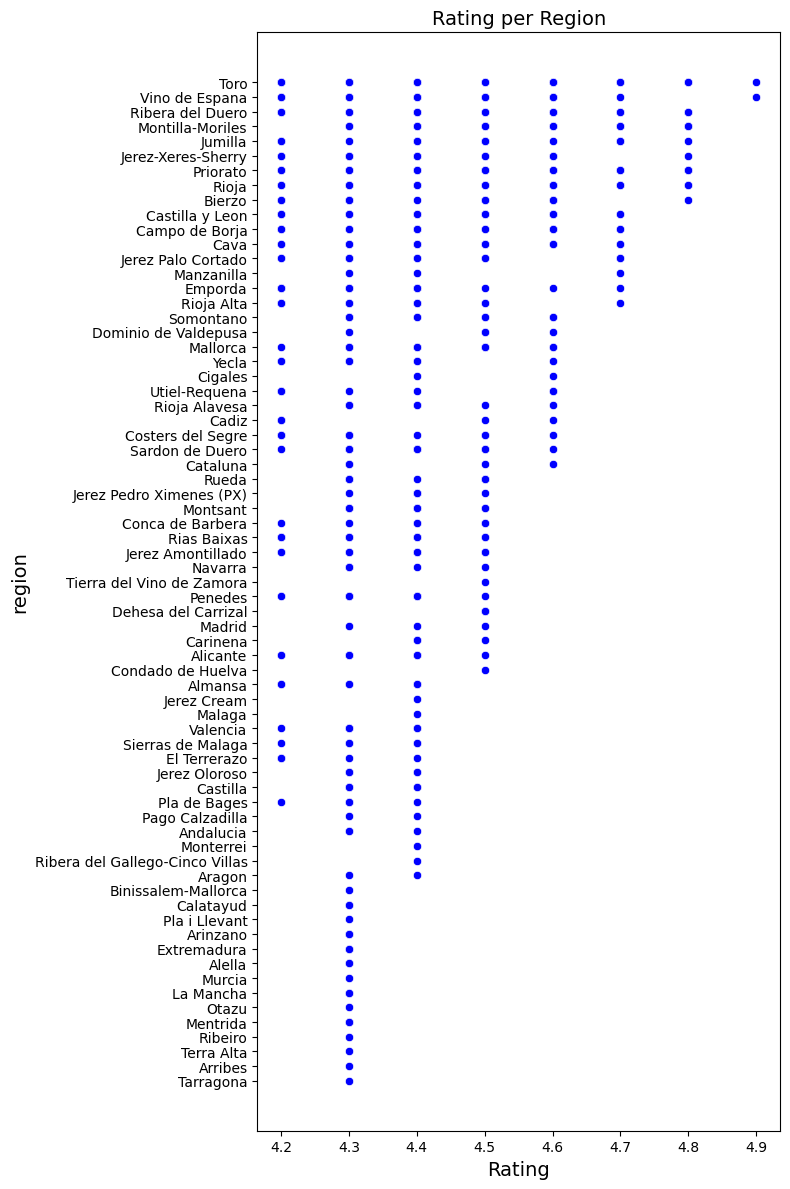

In [152]:
# make plot
fig, ax = plt.subplots(figsize = (8,12))

# labels
ax.set_title('Rating per Region', 
             fontsize = 14) 
ax.set_ylabel('', fontsize = 14) 
ax.set_xlabel('Rating', fontsize = 14)

# scatterplot
sns.scatterplot(data = df, 
               x = 'rating', 
               y = 'region',
               ax = ax,
               c = 'blue')
# display
plt.tight_layout()
plt.show()

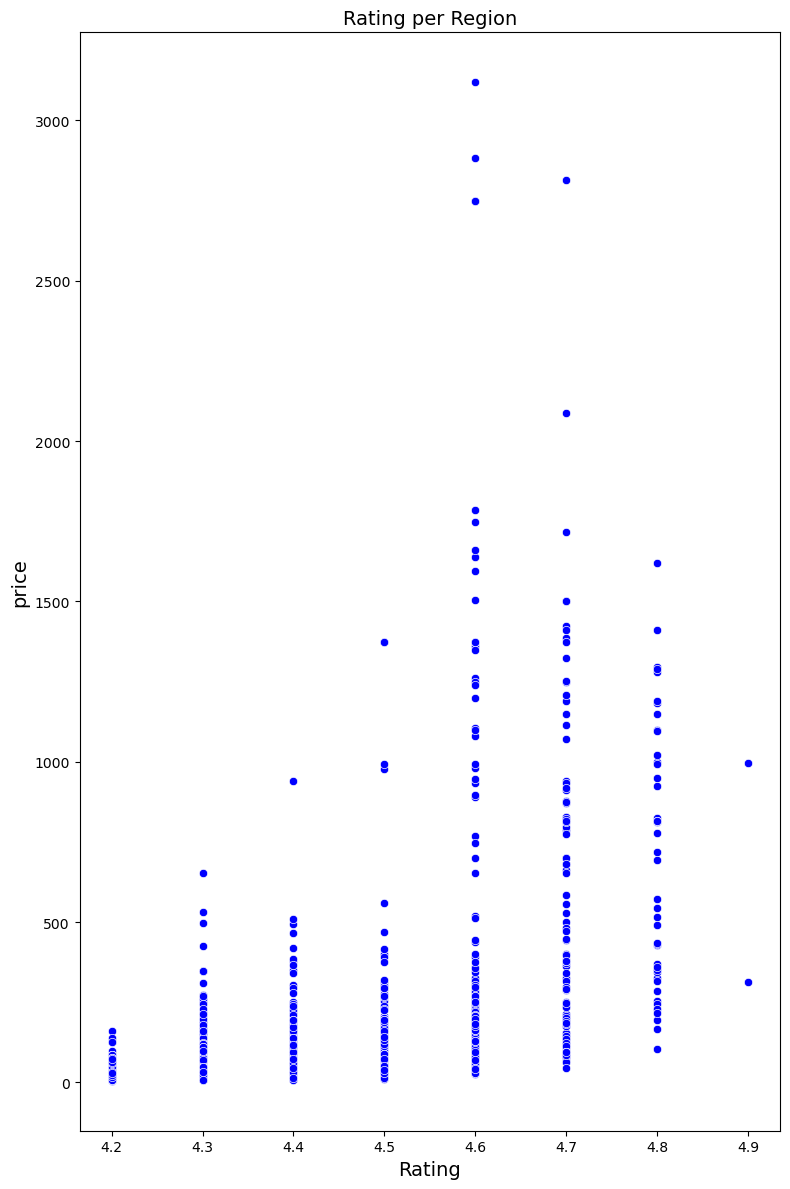

In [153]:
# make plot
fig, ax = plt.subplots(figsize = (8,12))

# labels
ax.set_title('Rating per Region', 
             fontsize = 14) 
ax.set_ylabel('', fontsize = 14) 
ax.set_xlabel('Rating', fontsize = 14)

# scatterplot
sns.scatterplot(data = df, 
               x = 'rating', 
               y = 'price',
               ax = ax,
               c = 'blue')
# display
plt.tight_layout()
plt.show()

Wine from the Toro and Vino de Espana have highest ratings at 4.9 being the peak. But 4.3 being the most average rating across the country.

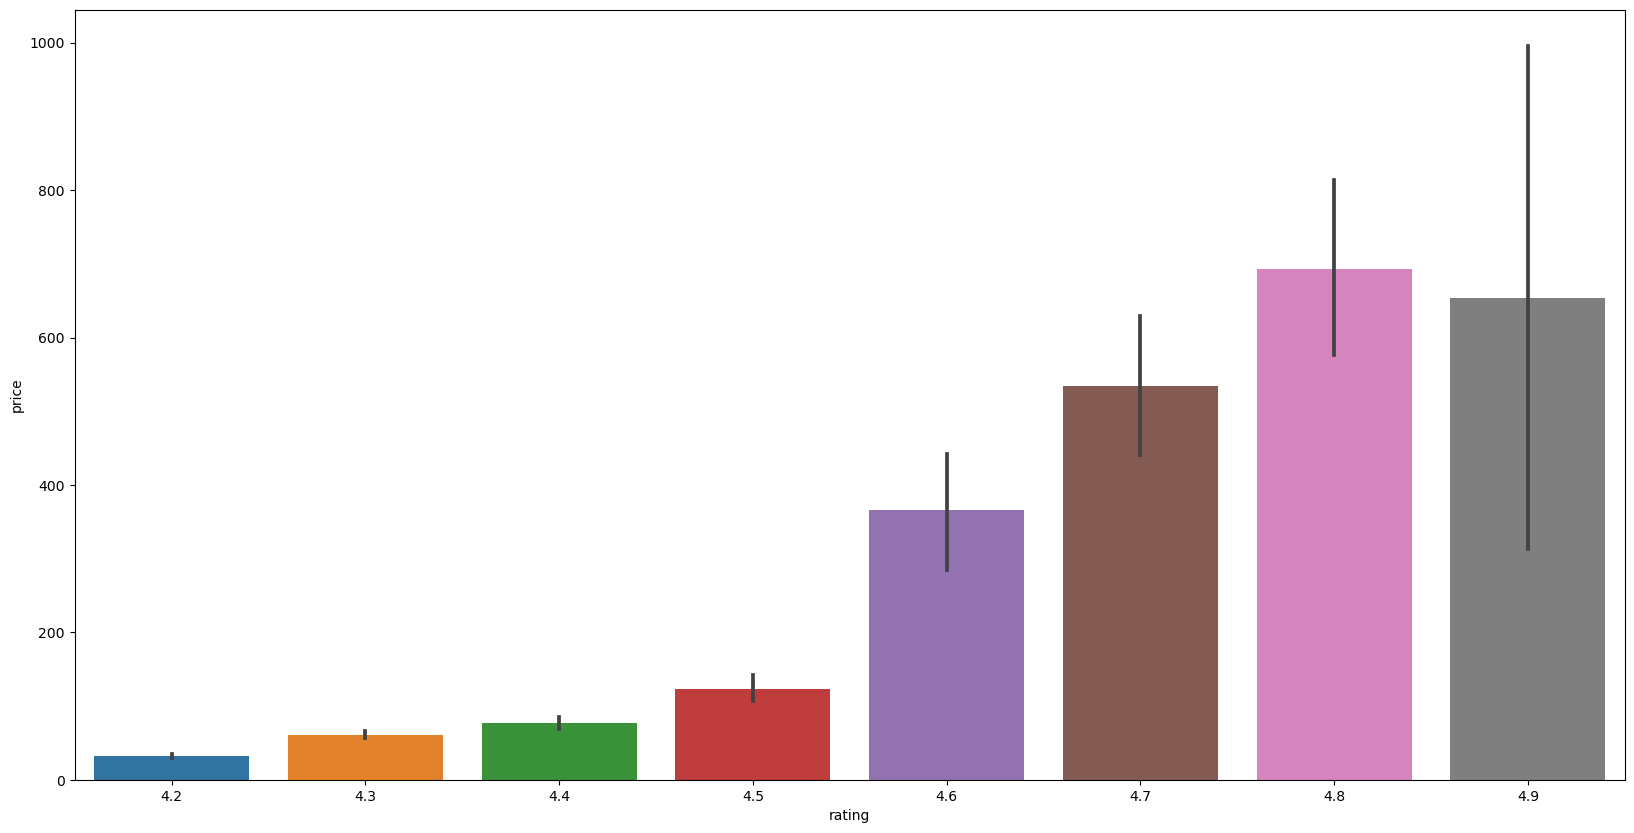

In [154]:
fig, ax = plt.subplots(figsize = (20,10))
ax = sns.barplot(data=df, x='rating', y='price')

Wine which are on the pricier side tend to have the best ratings but that doesn't mean the lower wines are bad/not good tasting.

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1940 entries, 0 to 6100
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wine         1940 non-null   object 
 1   year         1940 non-null   object 
 2   rating       1940 non-null   float64
 3   num_reviews  1940 non-null   int64  
 4   region       1940 non-null   object 
 5   price        1940 non-null   float64
 6   type         1940 non-null   object 
 7   body         1775 non-null   float64
 8   acidity      1775 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 151.6+ KB


LR Model

In [156]:
#features (X) and target (y)
y = df['rating'].astype('str')
X = df.drop(columns='rating')

#test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [157]:
#column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

In [158]:
#transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

#Imputer
number_imputer = SimpleImputer(strategy = 'mean')
frequent_imputer = SimpleImputer(strategy= 'most_frequent')
#pipes
num_pipe = make_pipeline (number_imputer, scaler)
cat_pipe = make_pipeline (frequent_imputer, ohe)

In [159]:
#Tuples
number_tuple = (num_pipe, num_selector)
category_tuple = (cat_pipe, cat_selector)
#Preprocessor
preprocessor = make_column_transformer (number_tuple,
                                        category_tuple)
#instance of the model
log_reg = LogisticRegression()
#pipeline
log_reg_pipe = make_pipeline(preprocessor, log_reg)
#Fit the model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                ('logisticregression', LogisticRegression())])

In [160]:
#Save the model predictions 
train_preds = log_reg_pipe.predict(X_train)

test_preds = log_reg_pipe.predict(X_test)

In [161]:
#print test pred
predictions = log_reg_pipe.predict(X_test)
predictions

array(['4.3', '4.3', '4.5', '4.3', '4.2', '4.4', '4.4', '4.3', '4.3',
       '4.3', '4.4', '4.3', '4.5', '4.3', '4.5', '4.4', '4.3', '4.5',
       '4.3', '4.4', '4.3', '4.4', '4.3', '4.5', '4.7', '4.4', '4.3',
       '4.2', '4.7', '4.5', '4.4', '4.3', '4.3', '4.4', '4.5', '4.2',
       '4.7', '4.2', '4.3', '4.3', '4.3', '4.5', '4.3', '4.3', '4.3',
       '4.3', '4.3', '4.3', '4.3', '4.8', '4.3', '4.4', '4.4', '4.7',
       '4.3', '4.4', '4.3', '4.4', '4.3', '4.5', '4.4', '4.3', '4.6',
       '4.4', '4.3', '4.3', '4.3', '4.3', '4.3', '4.4', '4.4', '4.3',
       '4.4', '4.3', '4.2', '4.6', '4.6', '4.2', '4.4', '4.3', '4.4',
       '4.3', '4.2', '4.6', '4.3', '4.4', '4.4', '4.7', '4.3', '4.6',
       '4.4', '4.3', '4.3', '4.5', '4.8', '4.6', '4.4', '4.6', '4.3',
       '4.4', '4.3', '4.3', '4.3', '4.4', '4.3', '4.4', '4.3', '4.5',
       '4.2', '4.5', '4.3', '4.2', '4.3', '4.4', '4.5', '4.3', '4.4',
       '4.3', '4.3', '4.3', '4.4', '4.3', '4.3', '4.3', '4.3', '4.3',
       '4.7', '4.2',

In [162]:
#classification reports
print('Train Report')
print(classification_report(y_train, train_preds))
print('Test Report')
print(classification_report(y_test, test_preds))

Train Report
              precision    recall  f1-score   support

         4.2       0.83      0.67      0.74       165
         4.3       0.66      0.88      0.75       484
         4.4       0.72      0.70      0.71       360
         4.5       0.73      0.51      0.60       191
         4.6       0.62      0.50      0.55       132
         4.7       0.71      0.57      0.63        84
         4.8       0.78      0.57      0.66        37
         4.9       0.00      0.00      0.00         2

    accuracy                           0.70      1455
   macro avg       0.63      0.55      0.58      1455
weighted avg       0.71      0.70      0.69      1455

Test Report
              precision    recall  f1-score   support

         4.2       0.54      0.28      0.37        54
         4.3       0.41      0.64      0.50       159
         4.4       0.25      0.28      0.27       102
         4.5       0.25      0.12      0.16        86
         4.6       0.40      0.19      0.26        53

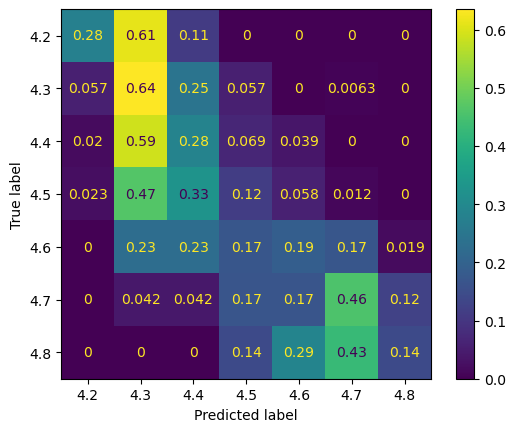

In [163]:
# LR confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize = 'true')

Best rated wine is at tied between 4.3 and 4.4 being at 61% and 64% I would assume stake holder want to sell more wine and new and returning customers. Model tuning to see if we can get a higher percentage to sell to new comers or returning customers.

In [164]:
#LG Tune
LGTuned = LogisticRegression(solver = 'liblinear', max_iter= 1000)

In [165]:
params = {'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C':
          [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [166]:
LGTuned_pipe = make_pipeline(preprocessor, LGTuned)
LGTuned_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

In [167]:
LGTuned_pipe.get_params()
LGTuned_grid_search = GridSearchCV(LGTuned_pipe, params)

In [168]:
LGTuned_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_f...,
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__penalty': ['l1', 'l2']})

In [169]:
LGTuned_grid_search.best_params_

{'logisticregression__C': 10, 'logisticregression__penalty': 'l1'}

In [170]:
LGbest_model = LGTuned_grid_search.best_estimator_
LGbest_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13567de80>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13567df70>)])),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [171]:
test_preds = LGbest_model.predict(X_test)
test_preds[:6]

array(['4.3', '4.3', '4.7', '4.3', '4.2', '4.4'], dtype=object)

In [172]:
print(classification_report (y_test, test_preds))

              precision    recall  f1-score   support

         4.2       0.59      0.44      0.51        54
         4.3       0.44      0.57      0.49       159
         4.4       0.27      0.31      0.29       102
         4.5       0.40      0.24      0.30        86
         4.6       0.50      0.23      0.31        53
         4.7       0.33      0.38      0.35        24
         4.8       0.21      0.43      0.29         7

    accuracy                           0.39       485
   macro avg       0.39      0.37      0.36       485
weighted avg       0.41      0.39      0.39       485



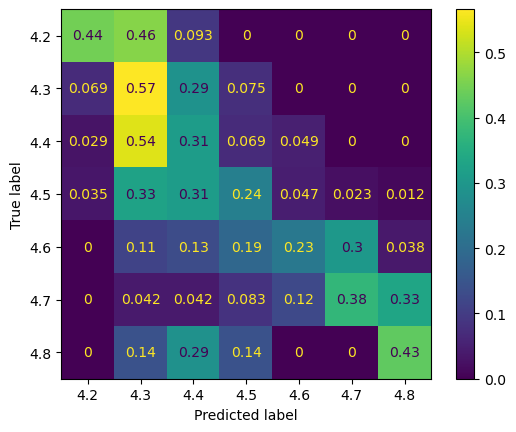

In [173]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize = 'true')

Tuning the Logistical Regression Model and using the hyperparameters of C=10 and L1. It would not benefit the stake holders since the percentage went down. I wouldn't recommend this model.

In [174]:
#RF Model
#features (X) and target (y)
y = df['rating'].astype('str')
X = df.drop(columns='rating')

In [175]:
#train test
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state= 42)

In [176]:
#tuples
number_tuple = (num_pipe, num_selector)
category_tuple = (cat_pipe, cat_selector)

#Preprocessor
preprocessor = make_column_transformer (number_tuple,
                                        category_tuple)

#instance of the model
rf = RandomForestClassifier()
#pipeline
rf_default_pipe = make_pipeline(preprocessor, rf)

In [177]:
rf_default_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                ('randomforestclassifier', RandomForestClassifier())])

In [180]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

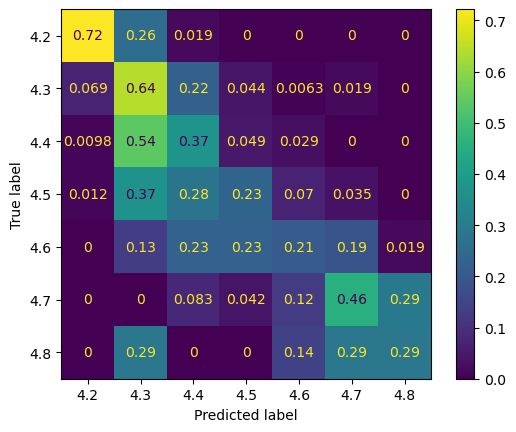

In [181]:
rf_default_predictions = rf_default_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, rf_default_predictions, normalize = 'true')

In [182]:
## print the classification reports
print('Train Report')
print(classification_report(y_train, train_preds))

print('Test Report')
print(classification_report(y_test, test_preds))

Train Report
              precision    recall  f1-score   support

         4.2       0.83      0.67      0.74       165
         4.3       0.66      0.88      0.75       484
         4.4       0.72      0.70      0.71       360
         4.5       0.73      0.51      0.60       191
         4.6       0.62      0.50      0.55       132
         4.7       0.71      0.57      0.63        84
         4.8       0.78      0.57      0.66        37
         4.9       0.00      0.00      0.00         2

    accuracy                           0.70      1455
   macro avg       0.63      0.55      0.58      1455
weighted avg       0.71      0.70      0.69      1455

Test Report
              precision    recall  f1-score   support

         4.2       0.59      0.44      0.51        54
         4.3       0.44      0.57      0.49       159
         4.4       0.27      0.31      0.29       102
         4.5       0.40      0.24      0.30        86
         4.6       0.50      0.23      0.31        53

RF model has 4.2 at 4.3 at 70% which is a huge improvement from LG Model and the tuned model. So far this model is the best for the stake holders.

In [184]:
#tuned RF
est_depths = [estimater.get_depth() for estimater in rf.estimators_]
max(est_depths)

146

In [185]:
rf_default_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                 

In [186]:
%%time
params = {'randomforestclassifier__max_depth': [1, max(est_depths), 20],}
          #'randomforestclassifier__n_estimators': [20, 50, 100, 200, 500, 1000],
          #'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
          #"randomforestclassifier__max_features": ['sqrt', 'log2', None]

rf_tuned = RandomForestClassifier()
rf_tuned_gs_pipe = GridSearchCV(rf_default_pipe, params)
rf_tuned_gs_pipe.fit(X_train, y_train)

CPU times: user 4.59 s, sys: 140 ms, total: 4.73 s
Wall time: 4.73 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [1, 146, 20]})

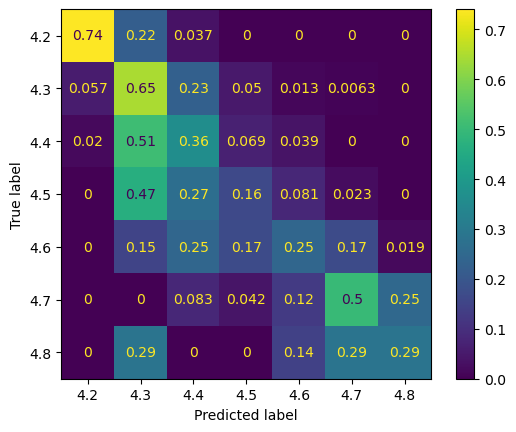

In [187]:
rf_tuned_gs_predictions = rf_tuned_gs_pipe.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, rf_tuned_gs_predictions, normalize = 'true')

The percentages went up slightly about for the tuned random forest model so either one of these is good stake holders.

# PCA

In [188]:
pca = PCA(n_components=.90)
pca_processor = make_pipeline(preprocessor, pca)

In [189]:
# LG
pca_rf_pipe = make_pipeline(pca_processor, rf)
pca_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                                 ('pca', PCA(n_components=0.9))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [190]:
train_preds = pca_rf_pipe.predict(X_train)
test_preds = pca_rf_pipe.predict(X_test)

In [191]:
#Metrics
## print the classification reports
print('Train Report')
print(classification_report(y_train, train_preds))

print('Test Report')
print(classification_report(y_test, test_preds))

Train Report
              precision    recall  f1-score   support

         4.2       1.00      1.00      1.00       165
         4.3       1.00      1.00      1.00       484
         4.4       1.00      1.00      1.00       360
         4.5       1.00      0.99      1.00       191
         4.6       1.00      1.00      1.00       132
         4.7       1.00      1.00      1.00        84
         4.8       1.00      1.00      1.00        37
         4.9       1.00      1.00      1.00         2

    accuracy                           1.00      1455
   macro avg       1.00      1.00      1.00      1455
weighted avg       1.00      1.00      1.00      1455

Test Report
              precision    recall  f1-score   support

         4.2       0.52      0.31      0.39        54
         4.3       0.42      0.62      0.50       159
         4.4       0.26      0.30      0.28       102
         4.5       0.31      0.15      0.20        86
         4.6       0.39      0.23      0.29        53

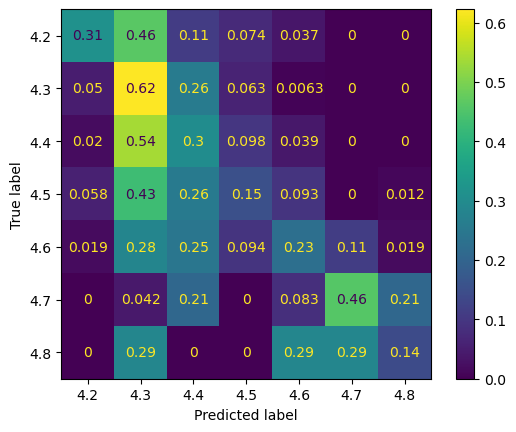

In [192]:
## create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize = 'true')

This one shows the highest being 62%. I wouldn't recommend the stake holders to use this, lets take a look at LR PCA model.

In [193]:
# LR PCA
pca_tuned_lr_pipe = make_pipeline(pca_processor, LGTuned)
pca_tuned_lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x1356143a0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13045de20>)])),
                                 ('pca', PCA(n_components=0.9))])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

In [194]:
## Save the model's predictions for the train dataset
train_preds = pca_tuned_lr_pipe.predict(X_train)
test_preds = pca_tuned_lr_pipe.predict(X_test)

In [195]:
# print the classification reports
print('Train Report')
print(classification_report(y_train, train_preds))

print('Test Report')
print(classification_report(y_test, test_preds))

Train Report
              precision    recall  f1-score   support

         4.2       0.57      0.31      0.40       165
         4.3       0.45      0.81      0.58       484
         4.4       0.40      0.31      0.35       360
         4.5       0.46      0.17      0.25       191
         4.6       0.46      0.30      0.36       132
         4.7       0.59      0.31      0.41        84
         4.8       0.71      0.32      0.44        37
         4.9       0.00      0.00      0.00         2

    accuracy                           0.46      1455
   macro avg       0.46      0.32      0.35      1455
weighted avg       0.47      0.46      0.43      1455

Test Report
              precision    recall  f1-score   support

         4.2       0.47      0.17      0.25        54
         4.3       0.39      0.78      0.52       159
         4.4       0.28      0.24      0.25       102
         4.5       0.21      0.06      0.09        86
         4.6       0.35      0.11      0.17        53

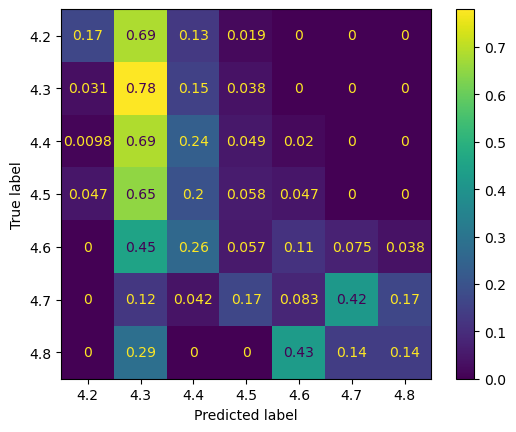

In [196]:
## create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize = 'true')

The highest is 78% for LR PCA which is a bit higher than the default Random Forest model, which means this one is in the best interest of the stake holders.

# Model choice

Based on the data gathered, I would recommend the company or people in charge to go with the PCA model of LR. Since 4.2 and 4.3 were the highest percent of rating, it gives people a bigger bubble to explore their options since these two are the most common rating across the country.